In [4]:
from tqdm import tqdm

import torchvision
import torch.nn as nn
import torch
import skimage
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

(512, 512)


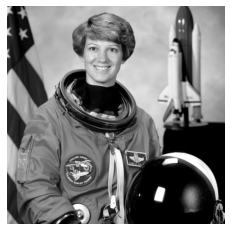

In [5]:
image = skimage.data.astronaut()
image = skimage.color.rgb2gray(image)
print(image.shape)
plt.imshow(image, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [6]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


In [7]:
SHAPE = 512
DEVICE = torch.device("cuda:0")
us = torch.linspace(-1, 1, steps=SHAPE)
vs = torch.linspace(-1, 1, steps=SHAPE)
u, v = torch.meshgrid(us, vs)
uv = torch.stack([u, v], dim=-1).to(DEVICE)
print("_uv shape: ", uv.shape)

/data/qtran/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
BATCH_SIZE = 4096
lr = 0.001
epochs = 2000

x_train = uv.view(-1, 2)
y_train = torch.from_numpy(image).float().view(-1, 1)
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)
model = MultiLayerPerceptron().to(DEVICE)
loss_func = nn.L1Loss().to(DEVICE)
N, C = x_train.shape

optim = torch.optim.AdamW(model.parameters(), lr=lr)
for epoch in tqdm(range(epochs)):
    for i in range((N - 1) // BATCH_SIZE + 1):
        #         set_trace()
        optim.zero_grad()
        start_i = i * BATCH_SIZE
        end_i = start_i + BATCH_SIZE
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model.forward(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        optim.step()

print(f"{epoch: } {loss}")

In [ ]:
x_test = uv.view(-1, 2) * 1
y_test = model.forward(x_test)

y_image = y_test.squeeze().reshape(SHAPE, SHAPE).cpu().detach().numpy()

plt.imshow(y_image, cmap=plt.cm.gray)
plt.axis("off")
plt.show()